## Exercise 5: 2d regression using LBFGS
Modify the code to solve a partial differential equation 
$$
\frac{dz}{dt} = 0.05 \frac{d^2z}{dx^2}
$$
in the domain $t = (0,1)$ and $x = (0,1)$

The boundary conditions are $z(x,0) = x(1-x)$

Using the finite difference method, we implement the differential equation. This is optimized using a mean squared error.
The boundary condition is also used and scaled by a factor of 100 to prioritize this inizially.

0   0.4039691090583801
100   0.0007157971849665046
200   0.0004845396615564823
300   0.0006102760089561343
400   0.0004936165641993284
500   0.0003327656304463744
600   0.00029735054704360664
700   0.000279541767667979
800   0.0003358882386237383
900   0.00033733638701960444
1000   0.0002960270212497562
1100   0.00027560669695958495
1200   0.00030975372646935284
1300   0.0003176386817358434
1400   0.00028189236763864756
1500   0.00026664455072022974
1600   0.00024244256201200187
1700   0.00028772299992851913
1800   0.0002844985865522176
1900   0.00025901879416778684


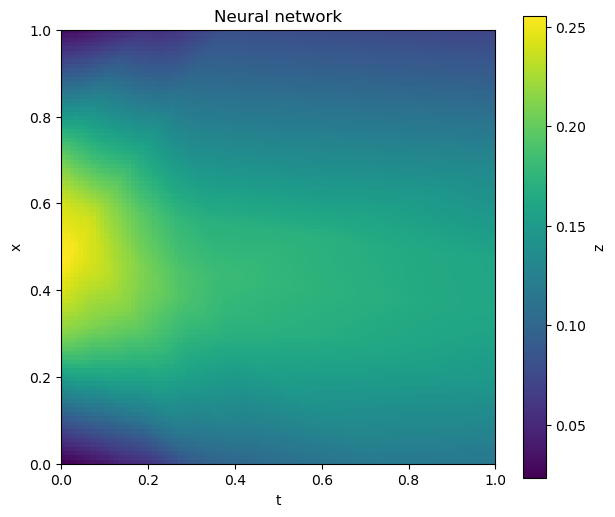

In [25]:
## This is a code to perform 2d regression using LBFGS
## Modify the code to solve the PDE 
## dz/dt = 0.05*d2z/dx2
## in the domain t = (0,1) and x = (0,1)
## The boundary conditions are z(x,0) = x*(1-x)

import torch
import matplotlib.pyplot as plt
from torch import nn, optim
import numpy as np

# Define the diffrential equation using automatic differentiation
def true_func(model, input_data,):
    x = input_data[:, 0].reshape(-1, 1)
    t = input_data[:, 1].reshape(-1, 1)

    h = 0.005
    dzdt = (model(torch.cat((x, t + h), 1)) - model(torch.cat((x, t - h), 1)))/(2*h)
    dzdt = dzdt[:,0]

    d2zdx2 = (model(torch.cat((x + h, t), 1)) - 2*model(input_data) + model(torch.cat((x - h, t), 1)))/(h*h)
    d2zdx2 = d2zdx2[:,0]


    return dzdt - 0.05*d2zdx2

# Create a grid of points, this time in x and t
x = torch.linspace(0, 1, 100)
t = torch.linspace(0, 1, 100)
xx, tt = torch.meshgrid(x, t)

# Define the boundary condition
def BC(guess, x, t):
    t0 = guess.reshape((x.shape[0],t.shape[0]))[:,0] # for t=0

    return t0 - x*(1-x) # Boundary condition at t=0  <-  z(x,0) = x*(1-x)

# Convert to PyTorch tensors
input_data = torch.cat((xx.reshape(-1, 1), tt.reshape(-1, 1)), 1)

input_data.requires_grad_(True)

# Define the neural network
model = nn.Sequential(
    nn.Linear(2, 100),
    nn.ReLU(),
    nn.Linear(100, 1),
)

# Define the loss function and the optimizer
criterion = lambda x: torch.square(x).mean()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define a closure function for re-evaluation
def loss_fn(model):
    prediction = true_func(model, input_data, )
    loss1 = criterion(prediction)

    bc = BC(model(input_data), x, t)
    loss2 = criterion(bc)

    loss = loss1/100. + loss2
    return loss

# Train the neural network
for step in range(2000):
    loss = loss_fn(model)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if(step%100==0):
      print(step," ",loss.item())

      


# Predict the function values at the grid points
with torch.no_grad():
    zz_pred = model(input_data).view_as(xx)

# Plot the true function and the neural network's approximation
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

c = ax.imshow(zz_pred, origin='lower', extent=(0, 1, 0, 1), cmap='viridis')
fig.colorbar(c, ax=ax, label = 'z')
ax.set_title('Neural network')
ax.set_xlabel('t')
ax.set_ylabel('x')
plt.show()

We get a diffusion! It does not look completely correct, so to sanity check we plot the first and last timestep along with the analytical boundary condition:

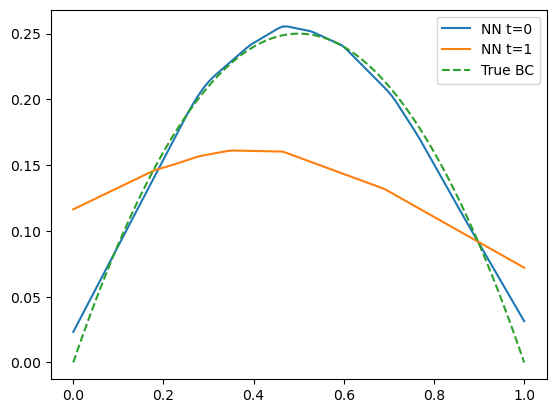

In [27]:
plt.plot(x, zz_pred[:,0], label='NN t=0')
plt.plot(x, zz_pred[:,-1], label='NN t=1')
plt.plot(x, x*(1-x), '--', label='True BC')
plt.legend()

As can be seen, the solution obeys the boundary condition (somewhat) but the diffusion has a slight bias towards one side. This changes for different runs, so we chalk this up to nummerical instabilities.